In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\human\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as tf_keras
from keras.callbacks import EarlyStopping

In [3]:
# !python -m pip install opencv-python

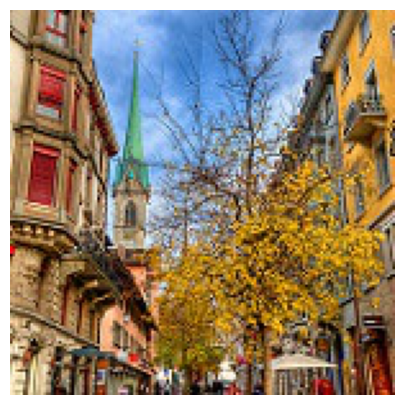

In [4]:
import cv2

plt.figure(figsize=(5, 5))
img = cv2.imread('data_files/seg_pred/seg_pred/10004.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

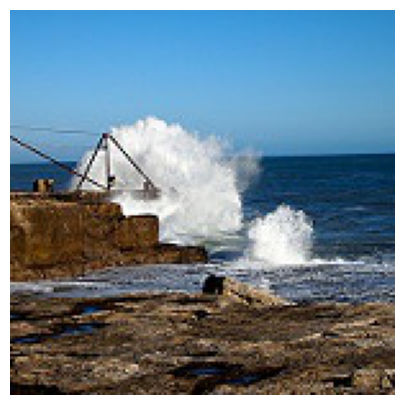

In [5]:
import cv2

plt.figure(figsize=(5, 5))
img = cv2.imread('data_files/seg_test/seg_test/sea/20072.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

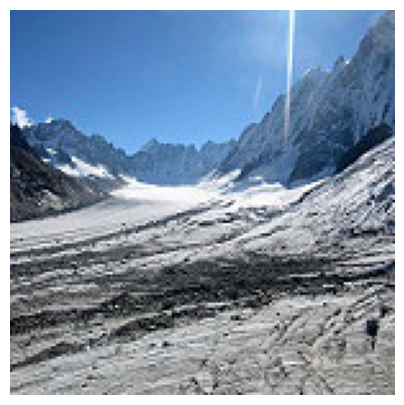

In [6]:
import cv2

plt.figure(figsize=(5, 5))
img = cv2.imread('data_files/seg_train/seg_train/glacier/10.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
# 입력 자동화 도구 만들기
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.2)  # Train:Validation 분할
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [5]:
# 입력 데이터 구성
# seg_train(train), seg_test(validation),  seg_pred(test)
# seg_train/seg_train/범주별폴더/각 범주의 사진들
# seg_test/seg_test/범주별폴더/각 범주의 사진들
# seg_pred/seg_pred/사진들
# 문의 결과 validation 할 때 train의 비율로 (validation_split) 나눠서 작업

datasets = []
for path, generator in zip(['seg_train', 'seg_test'],
                           [train_generator, test_generator]):
    if (path == 'seg_train'):
        dataset = generator.flow_from_directory(directory = f'data_files/{path}/{path}',
                                                target_size=(256, 256),
                                                batch_size=32,
                                                class_mode='categorical',
                                                subset='training')
        datasets.append(dataset)
        dataset = generator.flow_from_directory(directory = f'data_files/{path}/{path}',
                                                target_size=(256, 256),
                                                batch_size=32,
                                                class_mode='categorical',
                                                subset='validation')
        datasets.append(dataset)
    else:
      dataset = generator.flow_from_directory(directory = f'data_files/{path}/{path}',
                                              target_size=(256, 256),
                                              batch_size=32,
                                              class_mode='categorical')
      datasets.append(dataset)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


<class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>
(32, 256, 256, 3) (32, 6)
1.0
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


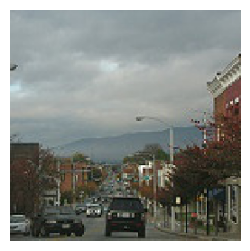

In [6]:
# 데이터 확인
print(type(datasets[0]))
for x_batch, y_batch in datasets[0]:
    print(x_batch.shape, y_batch.shape)
    print(x_batch[0].max())
    print(y_batch)
    break

plt.figure(figsize=(3, 3))
plt.imshow(x_batch[0])
plt.axis('off')
plt.show()

### 모델 설계

In [10]:
base_model = tf_keras.applications.VGG16(input_shape=(256, 256, 3),
                                         include_top=False,
                                         weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
# 모델 구조 설계
# 2 4 8 16 32 64 128 256 512 1024 2048 4096

input = tf_keras.layers.Input(shape=(256, 256, 3))
x = base_model(input)
x = tf_keras.layers.Flatten()(x)

x = tf_keras.layers.Dense(4096)(x)
x = tf_keras.layers.BatchNormalization()(x)
x = tf_keras.layers.Activation('relu')(x)
x = tf_keras.layers.Dropout(0.5)(x)

x = tf_keras.layers.Dense(1024)(x)
x = tf_keras.layers.BatchNormalization()(x)
x = tf_keras.layers.Activation('relu')(x)
x = tf_keras.layers.Dropout(0.5)(x)

x = tf_keras.layers.Dense(256)(x)
x = tf_keras.layers.BatchNormalization()(x)
x = tf_keras.layers.Activation('relu')(x)
x = tf_keras.layers.Dropout(0.4)(x)

x = tf_keras.layers.Dense(64)(x)
x = tf_keras.layers.BatchNormalization()(x)
x = tf_keras.layers.Activation('relu')(x)
x = tf_keras.layers.Dropout(0.3)(x)

x = tf_keras.layers.Dense(16)(x)
x = tf_keras.layers.BatchNormalization()(x)
x = tf_keras.layers.Activation('relu')(x)
x = tf_keras.layers.Dropout(0.2)(x)

output = tf_keras.layers.Dense(6, activation='softmax')(x)

full_model = tf_keras.Model(input, output)
full_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   134,221,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 153,433,654 (585.30 MB)

 Trainable params: 138,708,054 (529.13 MB)

 Non-trainable params: 14,725,600 (56.17 MB)

In [12]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, mode = 'auto')

full_model.compile(loss='categorical_crossentropy',
                   optimizer = 'adam',
                   metrics = ['accuracy'])

In [ ]:
fit_history = full_model.fit(datasets[0],
                             batch_size = 1,
                             epochs=70,
                             validation_data = datasets[1],
                             callbacks = [early_stopping])

Epoch 1/70


c:\Users\human\.conda\envs\fordl\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


236/351 ━━━━━━━━━━━━━━━━━━━━ 13:07 7s/step - accuracy: 0.5624 - loss: 1.2434

In [14]:
print( full_model.evaluate(datasets[0]), full_model.evaluate(datasets[2]))
# epoch=70(early_stopping해서 실epoch=9), train: 0.9810329675674438, test: 0.8673333525657654

351/351 ━━━━━━━━━━━━━━━━━━━━ 1536s 4s/step - accuracy: 0.9805 - loss: 0.0626
94/94 ━━━━━━━━━━━━━━━━━━━━ 414s 4s/step - accuracy: 0.8648 - loss: 0.4997
[0.06235216185450554, 0.9810329675674438] [0.47600018978118896, 0.8673333525657654]


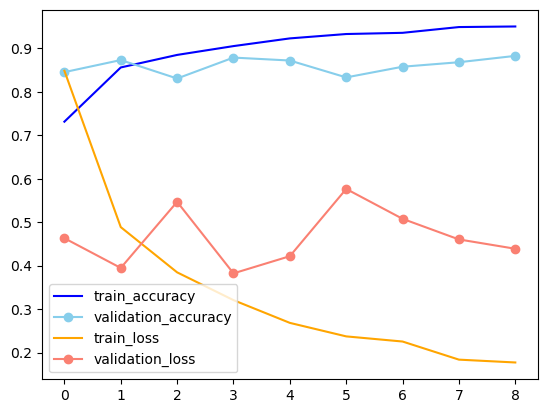

In [15]:
plt.plot(fit_history.epoch, fit_history.history['accuracy'], label='train_accuracy', c='blue')
plt.plot(fit_history.epoch, fit_history.history['val_accuracy'], label='validation_accuracy', c='skyblue', marker='o')
plt.plot(fit_history.epoch, fit_history.history['loss'], label='train_loss', c='orange')
plt.plot(fit_history.epoch, fit_history.history['val_loss'], label='validation_loss', c='salmon', marker='o')
plt.legend()
plt.show()

# 모델 개선 시도

In [7]:
base_model2 = tf_keras.applications.VGG16(input_shape=(256, 256, 3),
                                         include_top=False,
                                         weights='imagenet')
base_model2.trainable = True  # 또는 특정 층만 학습
for layer in base_model2.layers[:-4]:  # 마지막 4개의 층만 학습
    layer.trainable = False
base_model2.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [8]:
# 모델 구조 설계
# 2 4 8 16 32 64 128 256 512 1024 2048 4096

input = tf_keras.layers.Input(shape=(256, 256, 3))
x = base_model2(input)
x = tf_keras.layers.Flatten()(x)

x = tf_keras.layers.Dense(1024)(x)
x = tf_keras.layers.BatchNormalization()(x)
x = tf_keras.layers.Activation('relu')(x)
x = tf_keras.layers.Dropout(0.5)(x)

x = tf_keras.layers.Dense(512)(x)
x = tf_keras.layers.BatchNormalization()(x)
x = tf_keras.layers.Activation('relu')(x)
x = tf_keras.layers.Dropout(0.5)(x)

x = tf_keras.layers.Dense(256)(x)
x = tf_keras.layers.BatchNormalization()(x)
x = tf_keras.layers.Activation('relu')(x)
x = tf_keras.layers.Dropout(0.4)(x)

x = tf_keras.layers.Dense(128)(x)
x = tf_keras.layers.BatchNormalization()(x)
x = tf_keras.layers.Activation('relu')(x)
x = tf_keras.layers.Dropout(0.5)(x)

x = tf_keras.layers.Dense(64)(x)
x = tf_keras.layers.BatchNormalization()(x)
x = tf_keras.layers.Activation('relu')(x)
x = tf_keras.layers.Dropout(0.5)(x)

x = tf_keras.layers.Dense(32)(x)
x = tf_keras.layers.BatchNormalization()(x)
x = tf_keras.layers.Activation('relu')(x)
x = tf_keras.layers.Dropout(0.5)(x)

output = tf_keras.layers.Dense(6, activation='softmax')(x)

full_model2 = tf_keras.Model(input, output)
full_model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 48,977,766 (186.84 MB)

 Trainable params: 41,338,470 (157.69 MB)

 Non-trainable params: 7,639,296 (29.14 MB)

In [9]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, mode = 'auto')

full_model2.compile(loss='categorical_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])

In [10]:
fit_history2 = full_model2.fit(datasets[0],
                               batch_size = 1,
                               epochs=70,
                               validation_data = datasets[1],
                               callbacks = [early_stopping])

c:\Users\human\.conda\envs\fordl\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 2269s 6s/step - accuracy: 0.2737 - loss: 1.8445 - val_accuracy: 0.3402 - val_loss: 1.4391
Epoch 2/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 2238s 6s/step - accuracy: 0.4896 - loss: 1.1859 - val_accuracy: 0.6145 - val_loss: 0.9639
Epoch 3/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 2242s 6s/step - accuracy: 0.5767 - loss: 0.9312 - val_accuracy: 0.6049 - val_loss: 0.8036
Epoch 4/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 2244s 6s/step - accuracy: 0.5989 - loss: 0.8514 - val_accuracy: 0.6202 - val_loss: 0.7241
Epoch 5/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 2245s 6s/step - accuracy: 0.6210 - loss: 0.7973 - val_accuracy: 0.5578 - val_loss: 0.8675
Epoch 6/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 2246s 6s/step - accuracy: 0.6786 - loss: 0.7346 - val_accuracy: 0.6986 - val_loss: 0.7791
Epoch 7/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 2260s 6s/step - accuracy: 0.7373 - loss: 0.6484 - val_accuracy: 0.8028 - val_loss: 0.4601
Epoch 8/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 2246s 6s/step - accuracy: 0.7576 - loss: 0.5781 - 

In [11]:
print( full_model2.evaluate(datasets[0]), full_model2.evaluate(datasets[2]))
# epoch=70(early_stopping해서 실epoch= 9), train: 0.9810329675674438, test: 0.8673333525657654
# epoch=70(early_stopping해서 실epoch=28), train: 0.9804096221923828, test: 0.9100000262260437

351/351 ━━━━━━━━━━━━━━━━━━━━ 2784s 8s/step - accuracy: 0.9808 - loss: 0.0665
94/94 ━━━━━━━━━━━━━━━━━━━━ 850s 9s/step - accuracy: 0.9065 - loss: 0.3615
[0.07156311720609665, 0.9804096221923828] [0.35819506645202637, 0.9100000262260437]


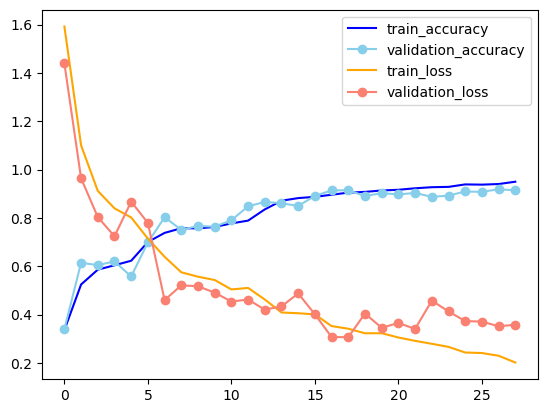

In [12]:
plt.plot(fit_history2.epoch, fit_history2.history['accuracy'], label='train_accuracy', c='blue')
plt.plot(fit_history2.epoch, fit_history2.history['val_accuracy'], label='validation_accuracy', c='skyblue', marker='o')
plt.plot(fit_history2.epoch, fit_history2.history['loss'], label='train_loss', c='orange')
plt.plot(fit_history2.epoch, fit_history2.history['val_loss'], label='validation_loss', c='salmon', marker='o')
plt.legend()
plt.show()